# This tutorial introduces the concepts of Machine Learing Using Dask.

Learning outcomes of the tutorial are:

1. Learn how to do data prepocessing.
2. Learn how to implement a linear regression model.
3. Learn how to implement a K-Means clustering Model.
4. Learn how to cross validate a model.
5. Learn how to build ML pipelines.

Prerequisite:

1. Experience with Scikit Learn library
2. Experience with Dask Dataframe and Dask Arrays

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline  # regular scikit-learn pipeline
import dask 
import dask.dataframe as dd
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler, MinMaxScaler
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression, LinearRegression
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans

In [2]:
import os
# The jupyter notebook is launched from your $HOME directory.
# Change the working directory to the workshop directory
# which was created in your username directory under /scratch/vp91
os.chdir(os.path.expandvars("/scratch/vp91/$USER/"))

In [3]:
# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

ddf = dd.read_csv("/scratch/vp91/Training-Data/Dask/weatherAUS.csv", dtype={'Humidity3pm': 'float64',
       'Humidity9am': 'float64',
       'WindGustSpeed': 'float64',
       'WindSpeed3pm': 'float64',
       'WindSpeed9am': 'float64'})
ddf.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data Prepocessing

The first process step in building a machine learning model is data cleaning. The data we have here is not very complex which makes data cleaning easier. In the production quality ML model, this is the most time-consuming step. 

Data cleaning mainly involves:
1. Remove any unnecessary observations from your dataset
2. Remove redundant information
3. Remove duplicate information
4. Remove structural errors in data collection
5. Remove unwanted outliers - outliers can result in overfitting
6. Handle missing data:
    * Remove observations with values missing
    * Infer the missing values

In this case, we are taking the easiest method to address missing values. We are removing any dataframe row that has missing values. This is not always advisable as we are losing a lot of information and in the end, we end up not getting the entire picture.

Inferring data is also not always a good idea as we may add some bias to the inference. 


In [4]:
ddf_clean = ddf.dropna() 
ddf_clean.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [5]:
shape = ddf_clean.shape
print(shape)

(Delayed('int-79bf402f-8693-4f37-be2c-d5cfba64d3a3'), 23)


In [6]:
print(type(shape[0]))
print(type(shape[1]))

<class 'dask.delayed.Delayed'>
<class 'int'>


As you can see the columns are immediately computed while the rows are not. We have invoked compute get the result.

In [7]:
shape[0].compute()

56420

In [17]:
ddf_clean.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Here, we are trying to predict the temperature based at 3PM.
1. We divide the data frame into target and features.
    * Target is the value we are trying to predict
    * Feature are the data points used to predict the target
2.  We remove all the features we deem unncessary

In [18]:
# Target
ddf_target = ddf_clean['Temp3pm']

Data usually have numerical data and categorical data. 
1. Categorical data groups information (usually text) with similar characteristics 
2. Numerical data expresses information in the form of numbers

Most machine learning algorithms cannot handle categorical variables unless it is converted to numerical data. This process is called encoding. 

Ideally, all categorical data should be converted to numerical data. In this case, we remove all catogorical data other than 'RainToday' and 'RainTomorrow'.

In [19]:
# Features
ddf_features = ddf_clean.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Temp3pm'])


In [20]:
ddf_features.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,No,No
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,No,No
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,No,No
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,No,No
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,No,No


In [21]:
shape = ddf_features.shape
print(shape)

(Delayed('int-9f6e4302-0b7d-4616-a0e7-bcc6075c14dd'), 17)


In [22]:
shape[0].compute()

56420

In [23]:
ddf_features.dtypes

MinTemp                  float64
MaxTemp                  float64
Rainfall                 float64
Evaporation              float64
Sunshine                 float64
WindGustSpeed            float64
WindSpeed9am             float64
WindSpeed3pm             float64
Humidity9am              float64
Humidity3pm              float64
Pressure9am              float64
Pressure3pm              float64
Cloud9am                 float64
Cloud3pm                 float64
Temp9am                  float64
RainToday        string[pyarrow]
RainTomorrow     string[pyarrow]
dtype: object

There are two types of categorical data in Dask
1. Known: categories are known statically (from the metadata)
2. Unknown: categories are not known statically (from the metadata)

**categorize()** function in meta scans the entire data find the different catogories in a feature. 

In [24]:
ddf_features = ddf_features.categorize()

In [25]:
ddf_features.dtypes

MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustSpeed     float64
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
RainToday        category
RainTomorrow     category
dtype: object

We can verify if the catogries of a feature are known as shown below

In [26]:
ddf_features.RainTomorrow.cat.known

True

Encoding is the method of converting categorical values into numerical values (and vice versa). There are two here we use **Dummy Encoding**. Each category end up getting a binary value.

In [27]:
de = DummyEncoder()
ddf_features_preproc = de.fit_transform(ddf_features.categorize())

In [28]:
ddf_features_preproc.head().reset_index()

,index,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
0,6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,True,False,True,False
1,6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,True,False,True,False
2,6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,True,False,True,False
3,6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,True,False,True,False
4,6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,True,False,True,False


In [29]:
ddf_features_preproc.dtypes

MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustSpeed       float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
RainToday_No           bool
RainToday_Yes          bool
RainTomorrow_No        bool
RainTomorrow_Yes       bool
dtype: object

In [30]:
ddf_features_preproc.RainToday_No = ddf_features_preproc.RainToday_No.replace({True: 1, False: 0})
ddf_features_preproc.RainToday_Yes = ddf_features_preproc.RainToday_Yes.replace({True: 1, False: 0})
ddf_features_preproc.RainTomorrow_No = ddf_features_preproc.RainTomorrow_No.replace({True: 1, False: 0})
ddf_features_preproc.RainTomorrow_Yes = ddf_features_preproc.RainTomorrow_Yes.replace({True: 1, False: 0})

In [31]:
ddf_features_preproc.dtypes

MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustSpeed       float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
RainToday_No          int64
RainToday_Yes         int64
RainTomorrow_No       int64
RainTomorrow_Yes      int64
dtype: object

## Standardization
Data standardization becomes relevant when there are substantial variations in the ranges of features within the input dataset or when those features are measured using different units (meteres, kilogram).

In [32]:
scaler = StandardScaler()
scalar_std = scaler.fit(ddf_features_preproc)

In [33]:
scalar_std.mean_

array([1.34647696e+01, 2.42192060e+01, 2.13039702e+00, 5.50313541e+00,
       7.73562566e+00, 4.08773662e+01, 1.56672279e+01, 1.97867777e+01,
       6.58741227e+01, 4.96019851e+01, 1.01723951e+03, 1.01479558e+03,
       4.24170507e+00, 4.32651542e+00, 1.82049610e+01, 7.79120879e-01,
       2.20879121e-01, 7.79741227e-01, 2.20258773e-01])

In [34]:
ddf_features_std = scaler.fit_transform(ddf_features_preproc)

In [35]:
ddf_features_std.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6049,0.691208,1.575298,-0.303702,1.757691,1.214537,0.534126,-1.162355,0.025055,-2.477924,-1.812261,-1.583303,-1.513002,-0.801428,0.254411,1.278186,0.532445,-0.532445,0.531485,-0.531485
6050,0.769131,0.671504,-0.303702,2.515216,1.400800,-0.290764,0.400721,-0.092452,-1.937767,-2.059824,-0.628068,-0.392322,-1.158937,-1.256603,0.318980,0.532445,-0.532445,0.531485,-0.531485
6052,0.924976,1.919600,-0.303702,1.433038,0.762183,0.384146,1.723325,-0.562482,-1.289578,-1.366647,-0.714907,-0.814396,-1.158937,0.632165,1.597921,0.532445,-0.532445,0.531485,-0.531485
6053,1.314588,2.034368,-0.303702,1.595364,1.187928,-0.740704,-1.162355,-1.620048,-1.559657,-1.366647,-0.657014,-0.828951,-1.158937,0.254411,1.658823,0.532445,-0.532445,0.531485,-0.531485
6054,1.673032,2.407362,-0.303702,1.541255,0.176784,-0.440744,0.160248,-0.797496,-2.531940,-1.713236,-0.946479,-1.076373,-1.158937,0.632165,2.343970,0.532445,-0.532445,0.531485,-0.531485


## Normalization

Normalization is the process of translating data into a range. It is a good practice to normalize the data - especially useful when different features have different value ranges. Normalization ensures that one feature does not overtly influence the model. 

In [36]:
MinMax = MinMaxScaler()

In [37]:
MinMax_scalar = MinMax.fit(ddf_features_std)

In [38]:
ddf_features_norm = MinMax.fit_transform(ddf_features_preproc)
ddf_features_norm.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6049,0.645669,0.706818,0.0,0.147783,0.848276,0.339130,0.061538,0.243243,0.20,0.13,0.430718,0.441748,0.250,0.555556,0.680798,1.0,0.0,1.0,0.0
6050,0.658793,0.563636,0.0,0.182266,0.896552,0.243478,0.261538,0.229730,0.30,0.08,0.540902,0.566343,0.125,0.111111,0.523691,1.0,0.0,1.0,0.0
6052,0.685039,0.761364,0.0,0.133005,0.731034,0.321739,0.430769,0.175676,0.42,0.22,0.530885,0.519417,0.125,0.666667,0.733167,1.0,0.0,1.0,0.0
6053,0.750656,0.779545,0.0,0.140394,0.841379,0.191304,0.061538,0.054054,0.37,0.22,0.537563,0.517799,0.125,0.555556,0.743142,1.0,0.0,1.0,0.0
6054,0.811024,0.838636,0.0,0.137931,0.579310,0.226087,0.230769,0.148649,0.19,0.15,0.504174,0.490291,0.125,0.666667,0.855362,1.0,0.0,1.0,0.0


## Correlation Matrix

Correlation is often used in machine learning to identify multicollinearity, which is when two or more predictor variables are highly correlated with each other. Multicollinearity can adversely affect the accuracy of predictive models.

* The coefficients become very sensitive to small changes in the model.
* Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model. 

Multicollinearity can be addressed by removing one of the correlated variables 

In [39]:
corr_matrix = ddf_features_norm.corr(method='pearson', min_periods=None, numeric_only='__no_default__', split_every=False)


In [40]:
corr_matrix.compute()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
MinTemp,1.000000,0.749687,0.110800,0.506764,0.076087,0.118054,0.108522,0.137273,-0.174991,0.070827,-0.475661,-0.495577,0.106177,0.042173,0.906295,-0.048953,0.048953,-0.087428,0.087428
MaxTemp,0.749687,1.000000,-0.069981,0.650964,0.463913,0.035531,-0.008171,0.012266,-0.495781,-0.448116,-0.350980,-0.451691,-0.263634,-0.257752,0.893387,0.221810,-0.221810,0.147467,-0.147467
Rainfall,0.110800,-0.069981,1.000000,-0.077239,-0.246379,0.106308,0.050584,0.044112,0.263625,0.277625,-0.180606,-0.137302,0.217169,0.191433,0.013713,-0.550515,0.550515,-0.254342,0.254342
Evaporation,0.506764,0.650964,-0.077239,1.000000,0.369250,0.209566,0.193154,0.124345,-0.554232,-0.422436,-0.297319,-0.325954,-0.199809,-0.202366,0.593122,0.218079,-0.218079,0.130002,-0.130002
Sunshine,0.076087,0.463913,-0.246379,0.369250,1.000000,-0.052422,-0.013842,0.029200,-0.500343,-0.629299,0.043330,-0.020632,-0.677939,-0.702022,0.289038,0.328904,-0.328904,0.453407,-0.453407
WindGustSpeed,0.118054,0.035531,0.106308,0.209566,-0.052422,1.000000,0.608852,0.685236,-0.193410,-0.042653,-0.430363,-0.383683,0.088129,0.131590,0.085520,-0.146276,0.146276,-0.233158,0.233158
WindSpeed9am,0.108522,-0.008171,0.050584,0.193154,-0.013842,0.608852,1.000000,0.502226,-0.236795,-0.058449,-0.201518,-0.155484,0.034908,0.062507,0.053749,-0.083125,0.083125,-0.083904,0.083904
WindSpeed3pm,0.137273,0.012266,0.044112,0.124345,0.029200,0.685236,0.502226,1.000000,-0.100626,0.031843,-0.293155,-0.252095,0.068224,0.041475,0.114043,-0.085627,0.085627,-0.088862,0.088862
Humidity9am,-0.174991,-0.495781,0.263625,-0.554232,-0.500343,-0.193410,-0.236795,-0.100626,1.000000,0.685697,0.114575,0.172972,0.438962,0.348707,-0.423598,-0.379451,0.379451,-0.271033,0.271033
Humidity3pm,0.070827,-0.448116,0.277625,-0.422436,-0.629299,-0.042653,-0.058449,0.031843,0.685697,1.000000,-0.063454,0.024109,0.509223,0.510996,-0.151614,-0.385440,0.385440,-0.455358,0.455358


<Axes: >

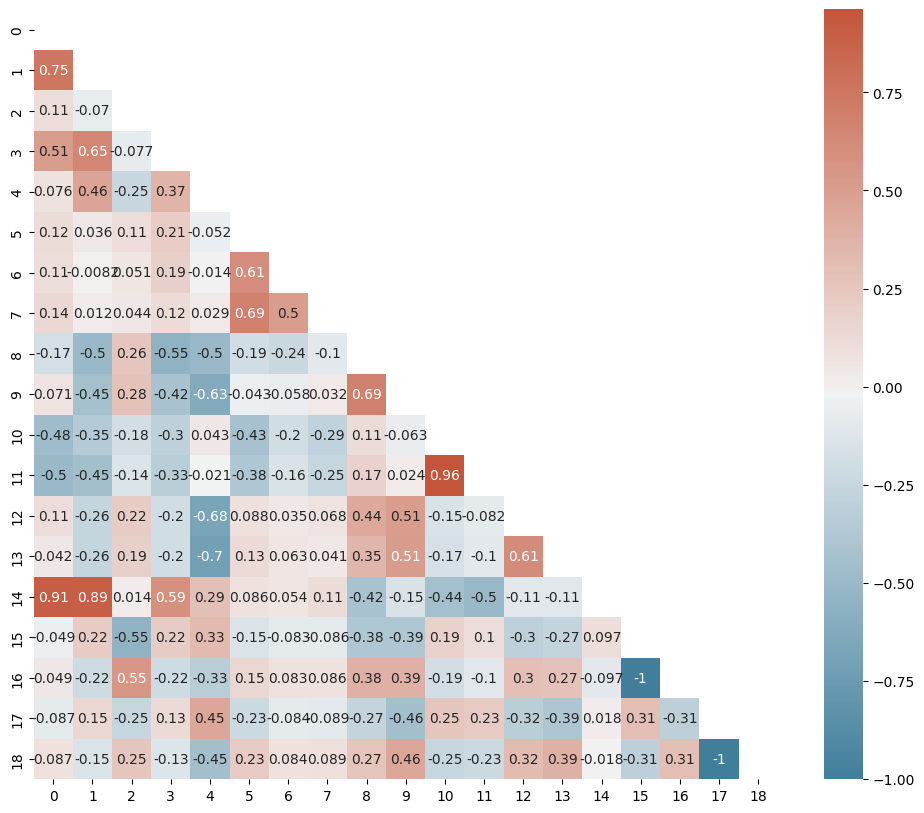

In [41]:

f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap)

Ideally we should remove one of the higly correlated feature or combine those together. For the time being we doing neither. 

## Principal Component Analysis

In [42]:

pca = PCA(n_components=3)
pca.fit(ddf_features_norm.to_dask_array(lengths=True))
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None, svd_solver='auto', tol=0.0, whiten=False)


PCA(iterated_power='auto', n_components=3)

In [43]:
pca.fit_transform(ddf_features_norm.to_dask_array(lengths=True))

dask.array<mul, shape=(56420, 3), dtype=float64, chunksize=(56420, 3), chunktype=numpy.ndarray>

In [44]:
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [45]:
print(pca.explained_variance_ratio_) 

[0.46272861 0.20258733 0.12956557]


In [46]:
pca.components_

array([[ 1.54527259e-02, -6.98063641e-02,  2.19776610e-02,
        -1.77289051e-02, -2.35112922e-01,  3.38627976e-02,
         1.56954765e-02,  1.59635232e-02,  1.29054509e-01,
         1.77793307e-01, -4.04059986e-02, -2.69793408e-02,
         2.78912644e-01,  2.36468298e-01, -2.99298837e-02,
        -4.22197855e-01,  4.22197855e-01, -4.44652429e-01,
         4.44652429e-01],
       [ 1.87172200e-02,  2.41483758e-02, -1.91712790e-02,
         8.14177723e-03, -7.43580876e-02,  1.63339610e-02,
         5.09698043e-04,  6.69778478e-04, -3.84588781e-02,
         2.61498324e-02, -1.49903661e-02, -2.55890121e-02,
         4.98729381e-02,  9.10586864e-02,  2.82345734e-02,
         5.35255797e-01, -5.35255797e-01, -4.50122169e-01,
         4.50122169e-01],
       [-8.15558368e-02, -1.60068666e-01, -7.77562400e-03,
        -3.40546674e-02, -3.66418964e-01, -5.11684094e-02,
        -3.40130179e-02, -2.85690380e-02,  1.73986012e-01,
         1.71218054e-01,  5.98846919e-02,  7.09809337e-02,
    

# Cross validation
Cross-validation is a method for evaluating ML models by training several ML models on subsets of the data and evaluating another subset of the data. The advantages of cross validation are : 

1. Identify Overfitting
2. Comparison between different models 
3. Hyperparameter tuning
4. Efficiency : Allows the use of data for both training and validation

We divide the dataset into training set and testing set. Training set is used to train the model, while the testing set will be used to measure the accuracy of the trained model.

In [47]:
#Divide into learning and test set

X_train, X_test, y_train, y_test = train_test_split(ddf_features_norm, ddf_target, shuffle=False)

In [48]:
X_train.compute().head()
X_test.compute().head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6057,0.598425,0.684091,0.000000,0.179803,0.910345,0.243478,0.200000,0.054054,0.25,0.09,0.547579,0.519417,0.125,0.111111,0.533666,1.0,0.0,1.0,0.0
6068,0.787402,0.802273,0.023278,0.147783,0.751724,0.434783,0.261538,0.202703,0.54,0.14,0.510851,0.508091,0.125,0.777778,0.690773,0.0,1.0,1.0,0.0
6082,0.795276,0.825000,0.002910,0.145320,0.841379,0.391304,0.107692,0.121622,0.42,0.17,0.465776,0.451456,0.125,0.222222,0.763092,1.0,0.0,0.0,1.0
6102,0.750656,0.704545,0.000000,0.110837,0.703448,0.295652,0.307692,0.297297,0.53,0.30,0.539232,0.538835,0.375,0.444444,0.663342,1.0,0.0,0.0,1.0
6139,0.648294,0.602273,0.000000,0.103448,0.772414,0.304348,0.200000,0.229730,0.55,0.36,0.597663,0.598706,0.125,0.666667,0.526185,1.0,0.0,1.0,0.0


In [49]:
y_train.compute().head()
y_test.compute().head()

6057    32.8
6068    37.0
6082    38.7
6102    34.0
6139    28.8
Name: Temp3pm, dtype: float64

In [54]:
y_train_array = y_train.to_dask_array(lengths=True)
X_train_array = X_train.to_dask_array(lengths=True)

In [55]:
X_train_array

dask.array<values, shape=(50799, 19), dtype=float64, chunksize=(50799, 19), chunktype=numpy.ndarray>

# Linear Regression
Linear regression is used to predict the value of a variable based on the value of another variable or a set of varibales. It a type of **Supervised Learning**. Supervised machine learning involves the process of establishing a connection between input variables and output variables. The input variabls are often called features or independent variables, while the output is commonly denoted as the target or 'dependent variables. Data containing both these features and the target is typically termed labeled data.

Linear regression tries to find the optimal W<sub>1</sub>, W<sub>2</sub>, W<sub>3</sub>, W<sub>4</sub>, so that we can predict the value of Y for the user-supplied X<sub>1</sub>, X<sub>2</sub>, X<sub>3</sub>.

$$
  Y(X_1, X_2, X_3) = W_1 * X_1 + W_2 * X_2 + W_3 * X_3 + W_4
$$

In [56]:
lr = LinearRegression(solver_kwargs={"normalize":False})

### Train the model

In [57]:
lr.fit(X_train_array, y_train_array)

LinearRegression(solver_kwargs={'normalize': False})

In [58]:
y_test_array = y_test.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)

In [59]:
predicted_value = lr.predict(X_test_array[0, :].reshape(1, 19))

In [60]:
predicted_value.compute()

array([31.86197924])

In [61]:
original_value = y_test_array[0]

In [62]:
original_value.compute()

32.8

### Score the performance of the model using test data

In [63]:
lr.score(X_test_array, y_test_array)

0.9806091658283931

# K-Means Clustering

k-means clustering partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centroid). k-means clustering is a type of **Unsupervised Learning**. In unsupervised learning the algorithm groups or patterns without the need of labeled data.

In [64]:
#https://calcofi.org/data/

ddf = dd.read_csv("/scratch/vp91/Training-Data/Dask/CalCOFI_bottle.csv", dtype={
       'O2Satq': 'float64',
       'O_qual': 'float64',
       'PO4q': 'float64',
       'S_prec': 'float64',
       'T_prec': 'float64',
       'C14A1q': 'float64',
       'C14A2q': 'float64',
       'Chlqua': 'float64',
       'DIC Quality Comment': 'object',
       'DarkAq': 'float64',
       'IncTim': 'object',
       'MeanAq': 'float64',
       'NH3q': 'float64',
       'NO2q': 'float64',
       'NO3q': 'float64',
       'P_qual': 'float64',
       'Phaqua': 'float64',
       'SiO3qu': 'float64'})
ddf.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


In [65]:
ddf.columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm', 'T_degC',
       'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum',
       'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim',
       'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP', 'DIC1',
       'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')

In [66]:
ddf = ddf[['Depthm', 'Salnty', 'STheta', 'R_PRES', 'T_degC', 'O2ml_L']]

In [67]:
ddf.head()

,Depthm,Salnty,STheta,R_PRES,T_degC,O2ml_L
0,0,33.440,25.649,0,10.50,NaN
1,8,33.440,25.656,8,10.46,NaN
2,10,33.437,25.654,10,10.46,NaN
3,19,33.420,25.643,19,10.45,NaN
4,20,33.421,25.643,20,10.45,NaN


In [68]:
ddf = ddf.dropna()

In [69]:
ddf.head()

,Depthm,Salnty,STheta,R_PRES,T_degC,O2ml_L
2160,0,33.030,25.364,0,10.30,5.90
2161,6,32.920,23.568,6,18.46,6.02
2162,10,32.951,25.304,10,10.29,6.04
2163,15,32.990,25.335,15,10.29,6.06
2164,20,33.005,25.339,20,10.33,6.04


In [70]:
# normalization

scaler = StandardScaler()
ddf = scaler.fit_transform(ddf)

<Axes: xlabel='T_degC', ylabel='Salnty'>

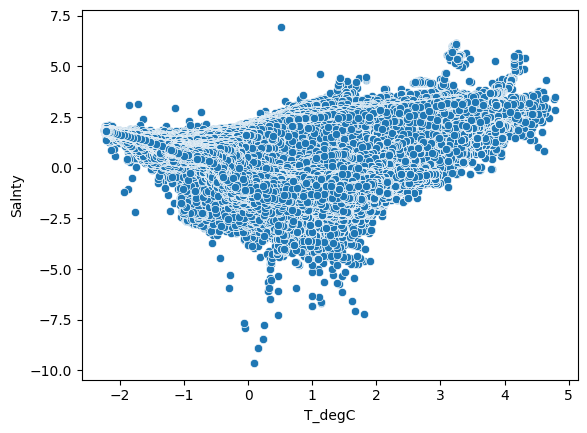

In [71]:
sns.scatterplot(data = ddf.compute(), x = 'T_degC', y = 'Salnty')

In [73]:
kmeans = KMeans(n_clusters=3, init_max_iter=1, oversampling_factor=8)

In [74]:
kmeans.fit(ddf)

KMeans(init_max_iter=1, n_clusters=3, oversampling_factor=8)

In [75]:
kmeans.labels_

dask.array<astype, shape=(661268,), dtype=int32, chunksize=(174046,), chunktype=numpy.ndarray>

<Axes: xlabel='T_degC', ylabel='Salnty'>

/scratch/vp91/Training-Venv/dask/dask-venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/scratch/vp91/Training-Venv/dask/dask-venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


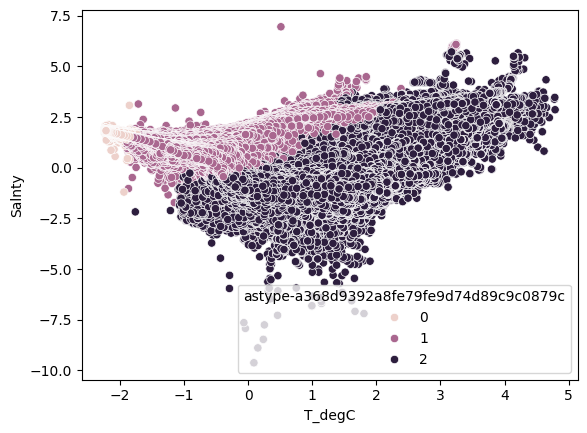

In [76]:
sns.scatterplot(data = ddf.compute(), x = 'T_degC', y = 'Salnty', hue = kmeans.labels_)

## Exercise
1. Test the result without data normalization
2. Apply other data preprocessing to the data
3. Change the number of clusters

# Pipelining
We saw that an ML workflow involves multiple stages. We can combine multiple stages of this workflow into a single pipeline. This is especially useful when your model is iterative. 

In [ ]:
pipe = Pipeline([('reduce_dim', PCA()), 
                 ('cluster', KMeans(n_clusters = 3, random_state = 0, n_init='auto'))
                ])

In [ ]:
pipe

In [ ]:
kmeans = pipe.fit(ddf.to_dask_array(lengths=True))

In [ ]:
sns.scatterplot(data = ddf.compute(), x = 'T_degC', y = 'Salnty', hue = pipe['cluster'].labels_)

# Excersice
1. Add normalization to the pipeline (Solutions1)